<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Downloading Model Output Plotting</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/siphon/latest/_static/siphon_150x150.png" alt="TDS" style="height: 200px;"></div>

### Questions
1. What is the netCDF Subset Service (NCSS)?
1. How can I use Siphon to make an NCSS request?
1. How do I plot gridded fields using CartoPy?

### Objectives
1. <a href="#ncss">Use siphon to make a request using NCSS</a>
1. <a href="#xarray">Creating an XArray Data Array</a>
1. <a href="#plotting">Make a Map</a>
1. <a href="#pointrequest">Requesting for a single point</a>

<a name="ncss"></a>
## 1. What is NCSS?

In [1]:
# Resolve the latest GFS dataset
import metpy
from siphon.catalog import TDSCatalog

# Set up access via NCSS
gfs_catalog = ('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
               'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
cat = TDSCatalog(gfs_catalog)
ncss = cat.datasets[0].subset()

We can see what variables are available from ncss as well:

In [2]:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_p

From here, we can build a query to ask for the data we want from the server.

In [3]:
from datetime import datetime, timedelta

# Create a new NCSS query
query = ncss.query()

# Request data in netCDF format
query.accept('netcdf')

# Ask for our variable
query.variables('Temperature_isobaric')

# Ask for the 500 hPa surface
query.vertical_level(50000)

# Set the time range of data we want
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))

# Set the spatial limits
query.lonlat_box(west=-110, east=-45, north=50, south=10)

# get the data!
data = ncss.get_data(query)

In [4]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Analysis from GFS (Global Forecast System)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/GFS/Global_0p5deg/GFS-Global_0p5deg.ncx3; Translation Date = 2020-01-14T21:12:44.326Z
    geospatial_lat_min: 10.0
    geospatial_lat_max: 50.0
    geospatial_lon_min: -110.0
    geospatial_lon_max: -45.0
    dimensions(sizes): time(8), isobaric6(1), lat(81), lon(131)
    variables(dimensions): float32 Temperatur

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="xarray"></a>
## 2. Creating an XArray Data Array

We know that the declarative plotting system works really well with XArray data arrays, so we need to get our NetCDF data into a data array. XArray makes this relatively easy with the NetCDF4DataStore backend.

In [5]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

# We need the datastore so that we can open the existing netcdf dataset we downloaded
ds = xr.open_dataset(NetCDF4DataStore(data))

In [6]:
ds

<xarray.Dataset>
Dimensions:               (isobaric6: 1, lat: 81, lon: 131, time: 8)
Coordinates:
    reftime               (time) datetime64[ns] ...
  * time                  (time) datetime64[ns] 2020-01-15 ... 2020-01-15T21:00:00
  * isobaric6             (isobaric6) float32 50000.0
  * lat                   (lat) float32 50.0 49.5 49.0 48.5 ... 11.0 10.5 10.0
  * lon                   (lon) float32 250.0 250.5 251.0 ... 314.0 314.5 315.0
Data variables:
    Temperature_isobaric  (time, isobaric6, lat, lon) float32 ...
    LatLon_Projection     int32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

We can explore the data with XArray, but for now we're most interested in which time steps are available so we can pick one to plot. Feel free to explore some of the other coordinates, data, and attributes of the data though!

In [7]:
ds.time

<xarray.DataArray 'time' (time: 8)>
array(['2020-01-15T00:00:00.000000000', '2020-01-15T03:00:00.000000000',
       '2020-01-15T06:00:00.000000000', '2020-01-15T09:00:00.000000000',
       '2020-01-15T12:00:00.000000000', '2020-01-15T15:00:00.000000000',
       '2020-01-15T18:00:00.000000000', '2020-01-15T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    reftime  (time) datetime64[ns] ...
  * time     (time) datetime64[ns] 2020-01-15 ... 2020-01-15T21:00:00
Attributes:
    standard_name:        time
    long_name:            GRIB forecast or observation time
    _CoordinateAxisType:  Time

We could do some rather ugly manipulation of numpy datetimes here, but instead we just say when we want the plot to be valid and MetPy will do it's best by plotting the nearest available time to our request!

In [8]:
# Create the desired plot time
plot_time = now + timedelta(hours=12)

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="plotting"></a>
## Make a Map

In [9]:
from metpy.plots.declarative import *
from metpy.units import units

Let's start out by making a very basic plot of the grid - we just want to get an idea of what's here.

In [10]:
# Make a basic image plot
img = ImagePlot()
img.data = ds
img.field = 'Temperature_isobaric'
img.level = 500 * units.hPa
img.time = plot_time

In [11]:
# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [img]

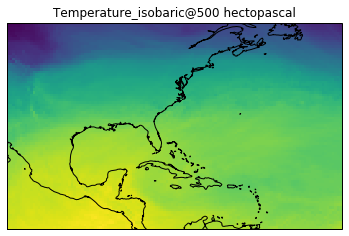

In [12]:
# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.show()

Now that we have a basic example working, we can get a little fancier and start dressing up our plot. Remember building up is easier to troubleshoot than writing it all in one shot! We do have to recreate the `ImagePlot`, `MapPanel`, and `PanelContainer` each time though due to how things are working under the hood to make declarative plotting possible.

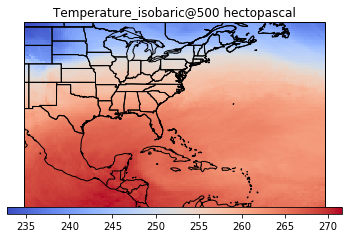

In [13]:
# Make a basic image plot
img = ImagePlot()
img.data = ds
img.field = 'Temperature_isobaric'
img.level = 500 * units.hPa
img.time = plot_time
img.colormap = 'coolwarm'
img.colorbar = 'horizontal'

# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [img]
panel.layers = ['coastline', 'borders', 'states']

# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
        <li>Extend the plot above by plotting contours of 500 hPa geopotential heights onto the temperature image plot. (You'll need to get the data.)</li>
        <li>Add a title to the plot with the correct time.</li>
         <li>Increase the figure size for a better look.</li>
    </ul>
</div>

In [14]:
# Set up an NCSS query from thredds using siphon
# YOUR CODE GOES HERE

# Download data using NCSS and create Data Array
# YOUR CODE GOES HERE

# Get the first time step as a datetime
# YOUR CODE GOES HERE

# Make a temperature image plot
# YOUR CODE GOES HERE

# Make geopotential contour plot
# YOUR CODE GOES HERE

# Create a panel container and add the panel to it
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

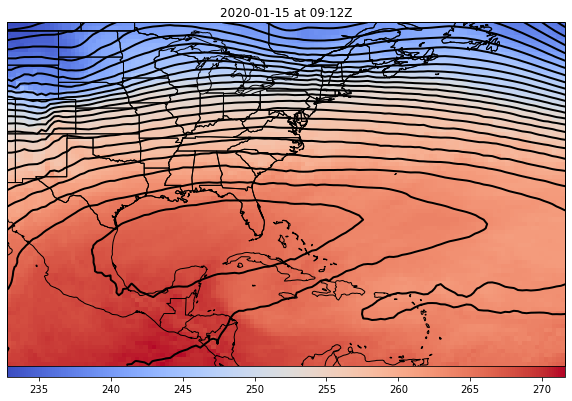

In [15]:
# %load solutions/dec_contour_map.py

# Cell content replaced by load magic replacement.
# Set up an NCSS query from thredds using siphon
query = ncss.query()
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Geopotential_height_isobaric')
query.vertical_level(50000)
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))
query.lonlat_box(west=-110, east=-45, north=50, south=10)

# Download data using NCSS and create Data Array
data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data))

# Get the first time step as a datetime
plot_time = now + timedelta(hours=12)

# Make a temperature image plot
tmp_img = ImagePlot()
tmp_img.data = ds
tmp_img.field = 'Temperature_isobaric'
tmp_img.level = 500 * units.hPa
tmp_img.time = plot_time
tmp_img.colormap = 'coolwarm'
tmp_img.colorbar = 'horizontal'

# Make geopotential contour plot
geopot_cnt = ContourPlot()
geopot_cnt.data = ds
geopot_cnt.field = 'Geopotential_height_isobaric'
geopot_cnt.level = 500 * units.hPa
geopot_cnt.time = plot_time

# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [tmp_img, geopot_cnt]
panel.layers = ['coastline', 'borders', 'states']
panel.title = plot_time.strftime('%Y-%m-%d at %H:%MZ')

# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)
pc.show()


We can even add wind barbs to the plot! We have to remove the level from our query though as winds are on a different coordinate that would be in hPa. That's okay though, when we plot we can select the correct level!

In [16]:
# Set up an NCSS query from thredds using siphon
query = ncss.query()
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Geopotential_height_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))
query.lonlat_box(west=-110, east=-45, north=50, south=10)

# Download data using NCSS and create Data Array
data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data))

# Create the desired plot time
plot_time = now + timedelta(hours=12)

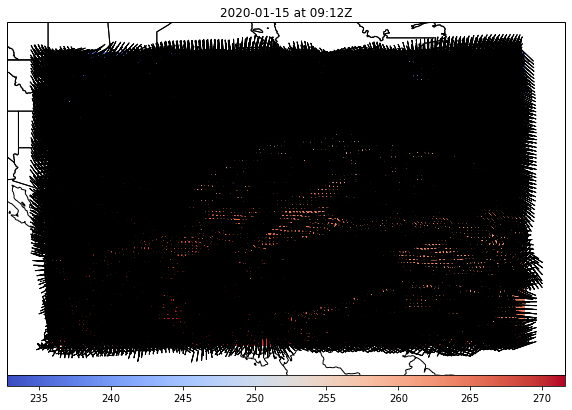

In [17]:
# Make a temperature image plot
tmp_img = ImagePlot()
tmp_img.data = ds
tmp_img.field = 'Temperature_isobaric'
tmp_img.level = 500 * units.hPa
tmp_img.time = plot_time
tmp_img.colormap = 'coolwarm'
tmp_img.colorbar = 'horizontal'

# Make geopotential contour plot
geopot_cnt = ContourPlot()
geopot_cnt.data = ds
geopot_cnt.field = 'Geopotential_height_isobaric'
geopot_cnt.level = 500 * units.hPa
geopot_cnt.time = plot_time

# Add wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.level = 500 * units.hPa
barbs.time = plot_time
barbs.field = ('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [tmp_img, geopot_cnt, barbs]
panel.layers = ['coastline', 'borders', 'states']
panel.title = plot_time.strftime('%Y-%m-%d at %H:%MZ')

# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)
pc.show()

There! We've got our plot and are ready to publish right? Wrong! There are obviously too many wind barbs there. We need to skip some (naive downsample).

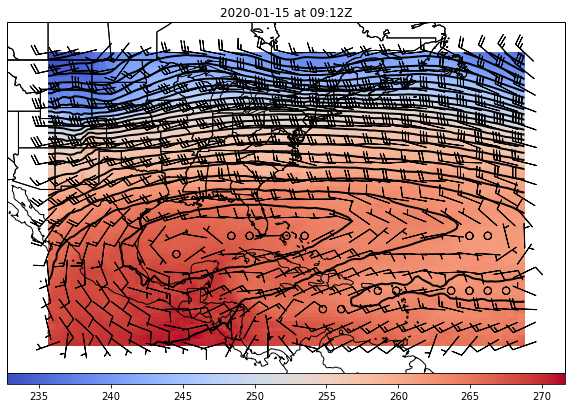

In [18]:
# Make a temperature image plot
tmp_img = ImagePlot()
tmp_img.data = ds
tmp_img.field = 'Temperature_isobaric'
tmp_img.level = 500 * units.hPa
tmp_img.time = plot_time
tmp_img.colormap = 'coolwarm'
tmp_img.colorbar = 'horizontal'

# Make geopotential contour plot
geopot_cnt = ContourPlot()
geopot_cnt.data = ds
geopot_cnt.field = 'Geopotential_height_isobaric'
geopot_cnt.level = 500 * units.hPa
geopot_cnt.time = plot_time

# Add wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.level = 500 * units.hPa
barbs.time = plot_time
barbs.field = ('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
barbs.skip = (5, 5)

# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [tmp_img, geopot_cnt, barbs]
panel.layers = ['coastline', 'borders', 'states']
panel.title = plot_time.strftime('%Y-%m-%d at %H:%MZ')

# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)
pc.show()


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
        <li>Set the area of the MapPanel to match our request area.</li>
    </ul>
</div>

In [19]:
# COPY THE MAP FROM ABOVE AND MODIFY IT HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

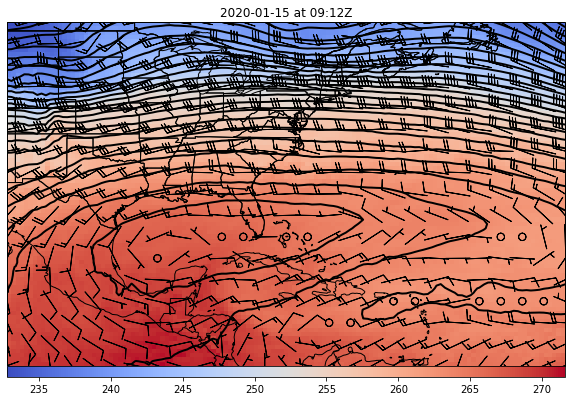

In [20]:
# %load solutions/dec_map_area.py

# Cell content replaced by load magic replacement.
# Make a temperature image plot
tmp_img = ImagePlot()
tmp_img.data = ds
tmp_img.field = 'Temperature_isobaric'
tmp_img.level = 500 * units.hPa
tmp_img.time = plot_time
tmp_img.colormap = 'coolwarm'
tmp_img.colorbar = 'horizontal'

# Make geopotential contour plot
geopot_cnt = ContourPlot()
geopot_cnt.data = ds
geopot_cnt.field = 'Geopotential_height_isobaric'
geopot_cnt.level = 500 * units.hPa
geopot_cnt.time = plot_time

# Add wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.level = 500 * units.hPa
barbs.time = plot_time
barbs.field = ('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
barbs.skip = (5, 5)

# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [tmp_img, geopot_cnt, barbs]
panel.layers = ['coastline', 'borders', 'states']
panel.title = plot_time.strftime('%Y-%m-%d at %H:%MZ')
panel.area = (-110, -45, 50, 10)

# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)
pc.show()


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
        <li>Create a new request/plot for different data from the model and create a new plot from scratch. Try to not copy/paste, but create from scratch or by typing copy at a minimum to help get your code muscles trained.</li>
    </ul>
</div>

In [21]:
# CREATE A DATA REQUEST

In [22]:
# CREATE A MAP

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


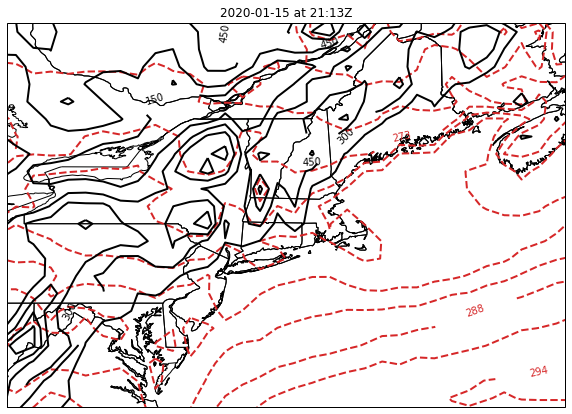

In [23]:
# %load solutions/dec_any_map.py

# Cell content replaced by load magic replacement.
# Set up access via NCSS
gfs_catalog = ('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
               'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
cat = TDSCatalog(gfs_catalog)
ncss = cat.datasets[0].subset()

# Set up an NCSS query from thredds using siphon
query = ncss.query()
query.accept('netcdf4')
query.variables('Temperature_surface', 'Geopotential_height_surface')
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))
query.lonlat_box(west=-110, east=-45, north=50, south=10)

# Download data using NCSS and create Data Array
data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data))

# Create the desired plot time
plot_time = now + timedelta(hours=24)

# Make temperature contour plot
temps_cnt = ContourPlot()
temps_cnt.data = ds
temps_cnt.field = 'Temperature_surface'
temps_cnt.linecolor = 'tab:red'
temps_cnt.linestyle = '--'
temps_cnt.time = plot_time
temps_cnt.clabels = True

# Make height contour plot
heights_cnt = ContourPlot()
heights_cnt.data = ds
heights_cnt.field = 'Geopotential_height_surface'
heights_cnt.time = plot_time
heights_cnt.clabels = True

# Create the map panel and add the plot to it
panel = MapPanel()
panel.plots = [temps_cnt, heights_cnt]
panel.layers = ['coastline', 'borders', 'states']
panel.title = plot_time.strftime('%Y-%m-%d at %H:%MZ')
panel.area = 'ma'

# Create a panel container and add the panel to it
pc = PanelContainer()
pc.panels = [panel]
pc.size = (10, 8)
pc.show()


<a href="#top">Top</a>
<hr style="height:2px;">